In [1]:
from sklearn.model_selection import train_test_split
from ipywidgets import FloatProgress
import numpy as np
from numba import jit ,f8
import h5py
from datetime import date
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import time

from denoise import denoise , denoise_pipeline , threshold
from utils import crop_bbox , draw_bbox  , convert_video_to_train_test
import os

from ipywidgets import *
from IPython.display import display
import os


## Load Videos

In [2]:
videos_dir = 'Videos'
videos_paths = os.listdir(videos_dir)
loaded_video_name = None
loaded_video = None
cropped_video  = None

gui = interact.options(manual=True,manual_name='load video')

@gui(file = videos_paths)
def load_video(file):
    '''
    Load the data video stored in numpy array of shape (frames,row,col,channel)
    '''
    global loaded_video,loaded_video_name
    
    #memap to load partially into ram
    loaded_video = np.load(f'{videos_dir}/{file}',mmap_mode='r')
    
    loaded_video_name= file
    
    print(f'loaded {file} \nshape = {loaded_video.shape}')
    

interactive(children=(Dropdown(description='file', options=('10%-0% -1-R1-HR-video.npy', '10%-1% -1-R1-HR-vide…

In [4]:
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

width,height= 90,15  #slider width and height

frame_slider = IntSlider(min=0,max=loaded_video.shape[0]-1,layout=Layout(width=f'{width}%',height=f'{height}px'),continuous_update=False)
threshold_slider = IntSlider(min=0,max=255,value=168,layout=Layout(width=f'{width}%',height=f'{height}px'),continuous_update=False)
tolerance_slider = IntSlider(min=0,max=255,value=0,layout=Layout(width=f'{width}%',height=f'{height}px'),continuous_update=False)
x_slider = IntSlider(min=0,max=loaded_video.shape[2],layout=Layout(width=f'{width}%',height=f'{height}px'),step=1,value=200,continuous_update=False)
y_slider = IntSlider(min=0,max=loaded_video.shape[1],layout=Layout(width=f'{width}%',height=f'{height}px'),step=1,value=1700,continuous_update=False)
w_slider = IntSlider(min=0,max=loaded_video.shape[2],layout=Layout(width=f'{width}%',height=f'{height}px'),step=1,value=200,continuous_update=False)
h_slider = IntSlider(min=0,max=loaded_video.shape[1],layout=Layout(width=f'{width}%',height=f'{height}px'),step=1,value=400,continuous_update=False)

gui_box= VBox([frame_slider,threshold_slider,tolerance_slider,x_slider,y_slider,w_slider,h_slider])


# global_row_frame,global_row_value = None , 1700

gui = interact.options(manual=False,manual_name='analyze')


@gui(frame =frame_slider,\
          threshold_value = threshold_slider,\
          tolerance_value = tolerance_slider,\
          x = x_slider,y = y_slider,w = w_slider,h = h_slider,\
          plot=True ,crop=False,save=False )
def crop_gui(frame,  \
                       threshold_value, \
                       tolerance_value ,\
                       x = x_slider,y = y_slider,w = w_slider,h = h_slider,\
                       plot=False,crop=False,save=False ):
    
    global loaded_video ,loaded_video_name,cropped_video
    
    if plot:
        plt.figure(1)
        plt.figure(figsize=(20,10))
        plt.yticks([]);plt.xticks([])
        img = loaded_video[frame:frame+1,:,:,:]

        #show raw image
        plt.subplot(1,3,1)
        plt.imshow(np.flip(draw_bbox(img[0].copy(),(x,y,w,h),t=10,color=(0,0,255)),2))
        plt.title('Raw image')

        #show threshold image
        plt.subplot(1,3,2)
        thresh = threshold(img,threshold_value) 
        if plot : plt.imshow(thresh[0,:,:,0],cmap='gray')
        plt.title('Thresholded image')

        #show streak image
        plt.subplot(1,3,3)
        denoised = denoise(thresh,tolerance = tolerance_value )
        if plot:plt.imshow(denoised[0,:,:,0],cmap='gray')     
        plt.title('Denoised image')
    
    if crop:
        #calculate the edges using the analysis pipeline
        tic =time.time()
        print('analysis in progress ...',end='\r')
        
        #crop video
        cropped_video = crop_bbox(loaded_video,(x,y,w,h))
        cropped_video  = denoise_pipeline(cropped_video , threshold_value , tolerance_value)
        toc=time.time()
        print(f'analysis done in {toc-tic} s')
        
        crop =False
        
    if crop and save :
        np.save(f'Time series/{loaded_video_name}-timeseries',global_row_frame)
        print('saved!')
        
        save = False


interactive(children=(IntSlider(value=0, continuous_update=False, description='frame', layout=Layout(height='1…

### Check the processed video

In [5]:
import cv2
gui = interact.options(manual=True,manual_name='play cropped video')

fi_slider = IntSlider(min=0,max=loaded_video.shape[0]-1,layout=Layout(width=f'{width}%',height=f'{height}px'),continuous_update=False)
@interact(fi=fi_slider)
def check_cropped_video(fi):
    plt.imshow(cropped_video[fi][:,:,0],cmap='gray')


interactive(children=(IntSlider(value=0, continuous_update=False, description='fi', layout=Layout(height='15px…

### Convert Video to Training data

In [6]:
x,xx,y,yy= convert_video_to_train_test(cropped_video,l=2,df=6,test_size= 0.05,verbose=True)

the reuslt size :534.6681213378906 MB
the result shape:(438, 2, 400, 400, 1)


### Build model

In [7]:
import wiggly_net
model= wiggly_net.build_model(x.shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 400, 400, 32)   160       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 400, 400, 32)   4128      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 400, 400, 32)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 200, 200, 32)   0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 200, 200, 32)   4128      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 200, 200, 32)   4128      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 200, 200, 32)   0

In [8]:
import tensorflow.keras as keras

filepath_model=f'test{x.shape}.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=filepath_model,save_weights_only=False,monitor='loss',mode='min',save_best_only=True)
reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 5, verbose = 1, cooldown=4,min_delta = 1e-4,min_lr=5e-8 )
history = model.fit(
    x,y,
    epochs=100,
    verbose=1 ,
    batch_size=1,
    callbacks=[model_checkpoint_callback,reduce_lr_callback],
    validation_data=(xx,yy)
)

Train on 416 samples, validate on 22 samples
Epoch 1/100
416/416 [==============================] - 45s 109ms/sample - loss: 0.1088 - mse: 0.1080 - val_loss: 0.1072 - val_mse: 0.1056
Epoch 2/100
416/416 [==============================] - 66s 159ms/sample - loss: 0.1081 - mse: 0.1057 - val_loss: 0.1062 - val_mse: 0.1027
Epoch 3/100
416/416 [==============================] - 53s 127ms/sample - loss: 0.0760 - mse: 0.0649 - val_loss: 0.0510 - val_mse: 0.0407
Epoch 4/100
416/416 [==============================] - 59s 142ms/sample - loss: 0.0481 - mse: 0.0393 - val_loss: 0.0465 - val_mse: 0.0397
Epoch 5/100
416/416 [==============================] - 65s 157ms/sample - loss: 0.0446 - mse: 0.0321 - val_loss: 0.0439 - val_mse: 0.0315
Epoch 6/100
416/416 [==============================] - 70s 168ms/sample - loss: 0.0393 - mse: 0.0241 - val_loss: 0.0404 - val_mse: 0.0280
Epoch 7/100
416/416 [==============================] - 72s 172ms/sample - loss: 0.0360 - mse: 0.0214 - val_loss: 0.0409 - val_m

Epoch 60/100
416/416 [==============================] - 36s 86ms/sample - loss: 0.0161 - mse: 0.0059 - val_loss: 0.0275 - val_mse: 0.0137
Epoch 61/100
416/416 [==============================] - 18s 44ms/sample - loss: 0.0162 - mse: 0.0059 - val_loss: 0.0269 - val_mse: 0.0138
Epoch 62/100
416/416 [==============================] - 39s 94ms/sample - loss: 0.0159 - mse: 0.0058 - val_loss: 0.0271 - val_mse: 0.0135
Epoch 63/100
416/416 [==============================] - 19s 45ms/sample - loss: 0.0161 - mse: 0.0058 - val_loss: 0.0269 - val_mse: 0.0135
Epoch 64/100
416/416 [==============================] - 19s 45ms/sample - loss: 0.0160 - mse: 0.0058 - val_loss: 0.0267 - val_mse: 0.0135
Epoch 65/100
416/416 [==============================] - 41s 97ms/sample - loss: 0.0159 - mse: 0.0058 - val_loss: 0.0269 - val_mse: 0.0135
Epoch 66/100
416/416 [==============================] - 62s 150ms/sample - loss: 0.0157 - mse: 0.0057 - val_loss: 0.0262 - val_mse: 0.0134
Epoch 67/100
416/416 [===========

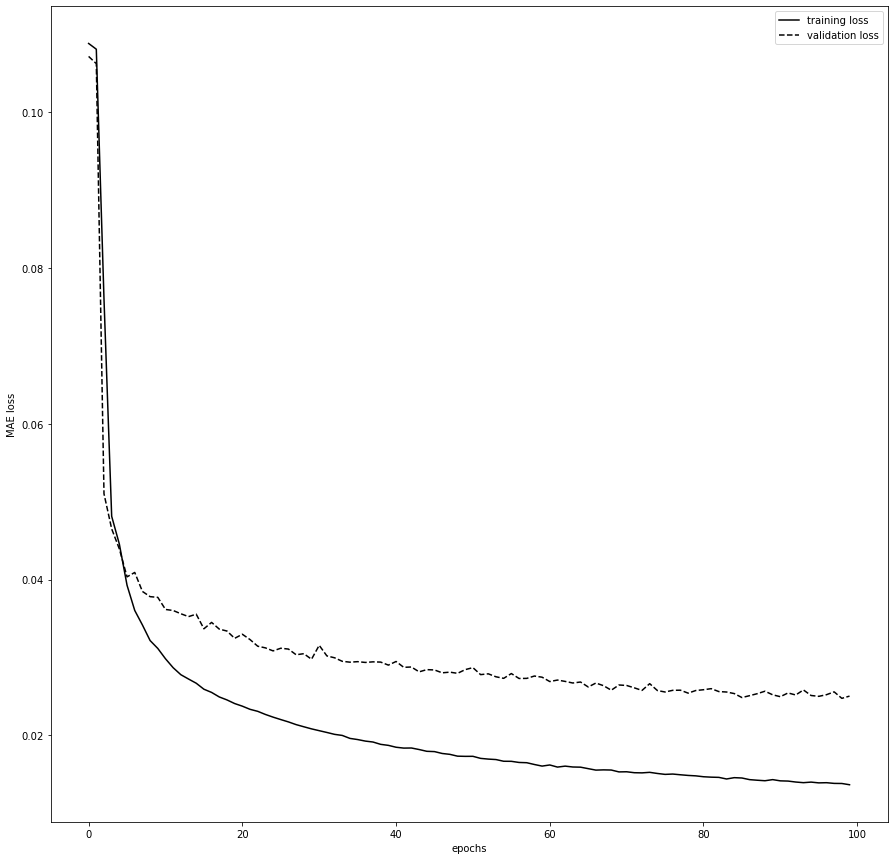

In [10]:
plt.figure(figsize=(15,15))
plt.plot(np.array(history.history['loss']),'-k')
plt.plot(np.array(history.history['val_loss']),'--k')
plt.xlabel('epochs');plt.ylabel('MAE loss')
plt.legend(['training loss','validation loss'])

### TEST

C:\Users\m\.conda\envs\deep\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


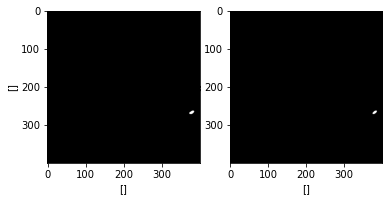

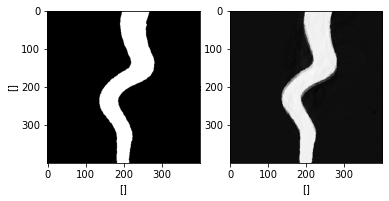

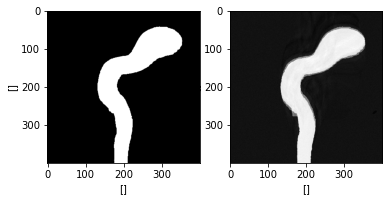

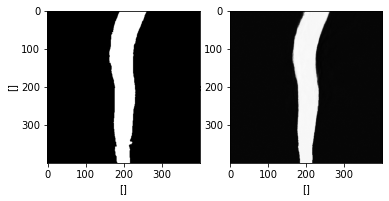

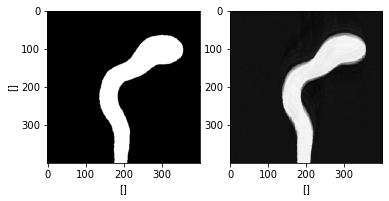

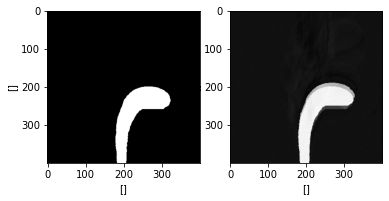

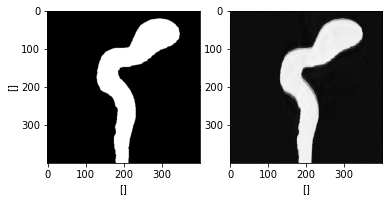

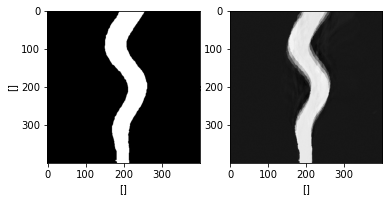

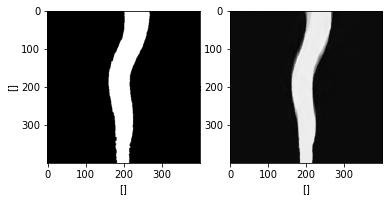

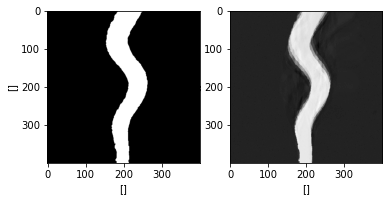

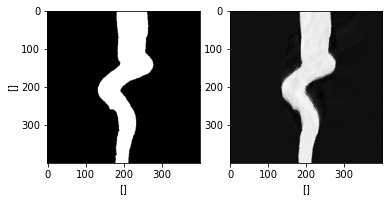

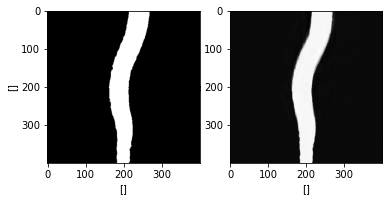

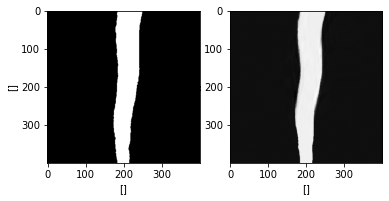

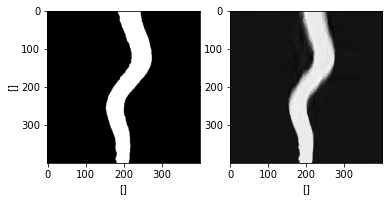

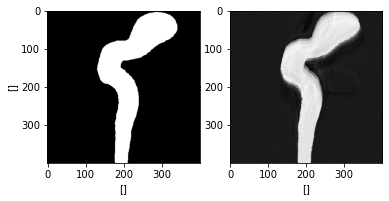

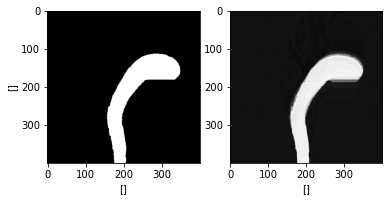

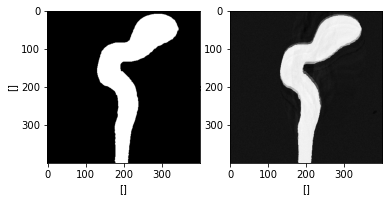

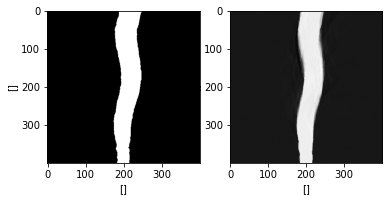

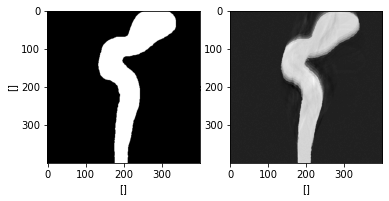

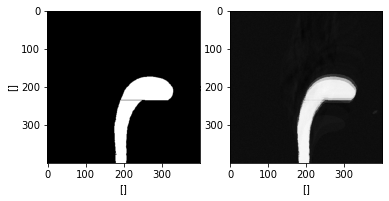

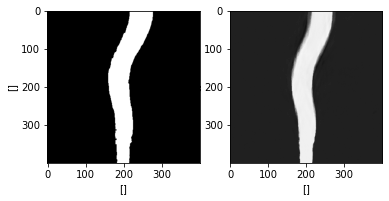

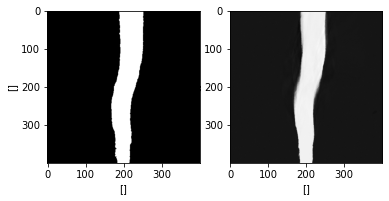

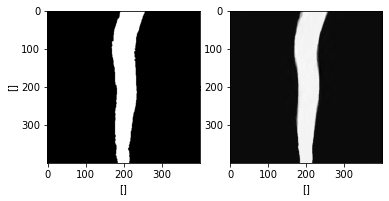

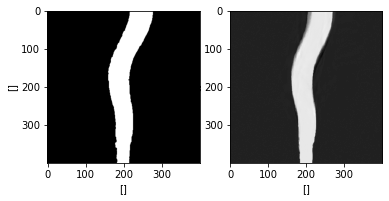

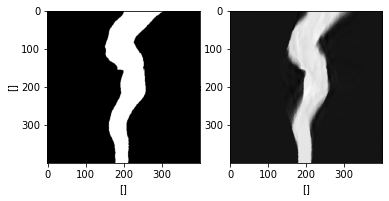

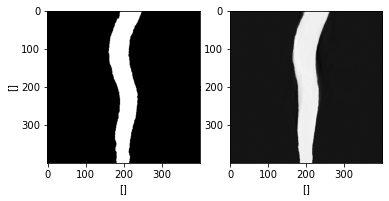

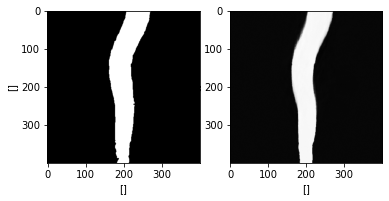

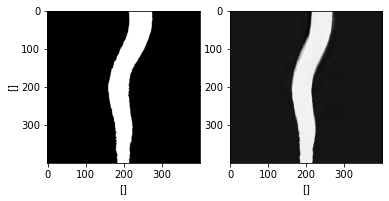

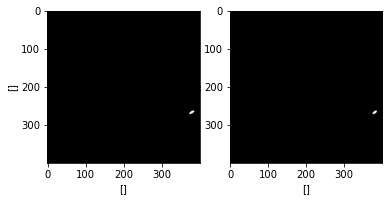

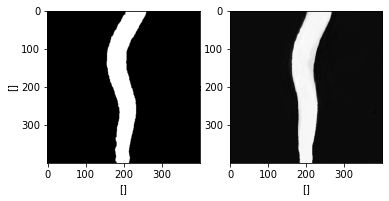

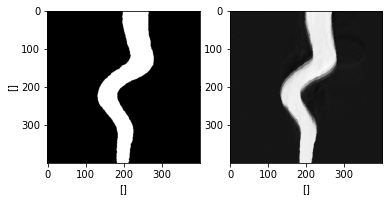

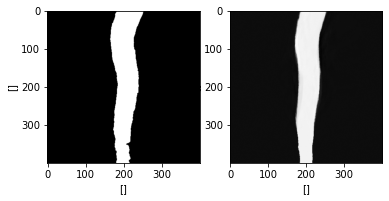

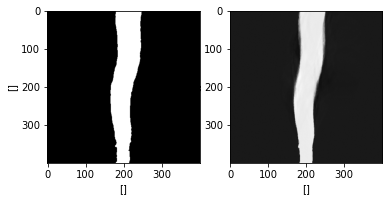

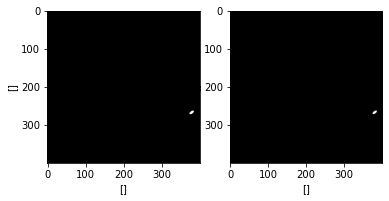

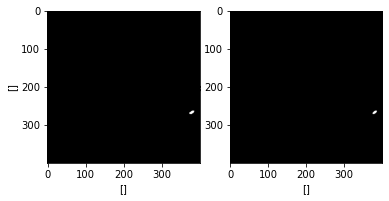

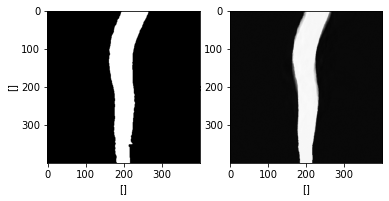

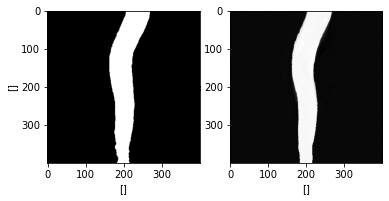

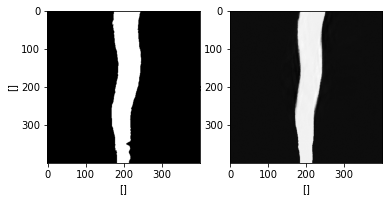

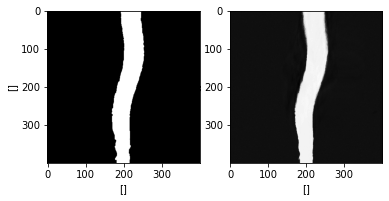

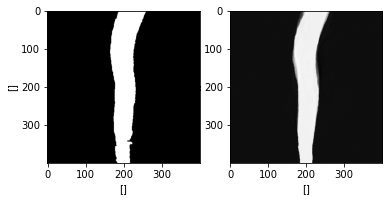

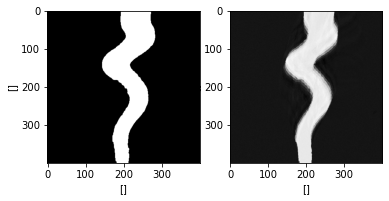

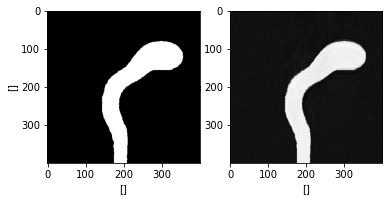

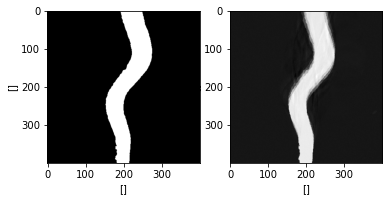

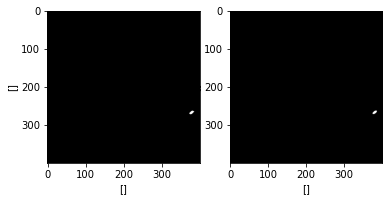

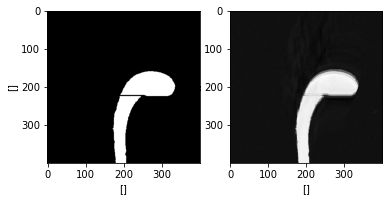

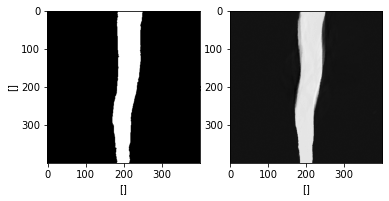

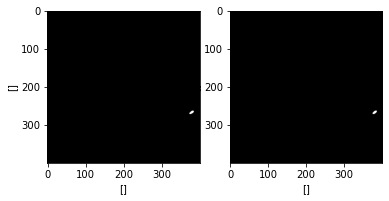

In [11]:
# testing on train data

for i in range(99,379,6):
    plt.figure()
    plt.subplot(1,2,1)
    plt.xlabel([]);plt.ylabel([])
    plt.imshow(y[i,0,:,:,0],cmap='gray')
    
    p = model.predict(x[i:i+1,:,:,:,:])*255
    plt.subplot(1,2,2)
    plt.xlabel([]);plt.ylabel([])
    plt.imshow(p[0,0,:,:,0],cmap='gray')
    
    key = cv2.waitKey(0) & 0xff
    if key == 27 : break


C:\Users\m\.conda\envs\deep\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


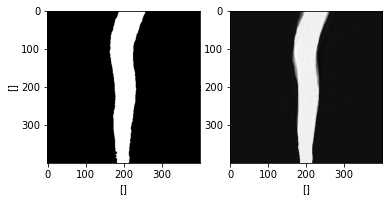

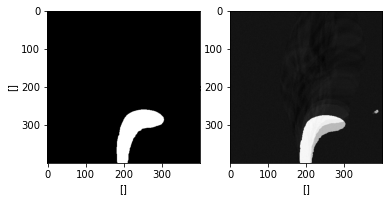

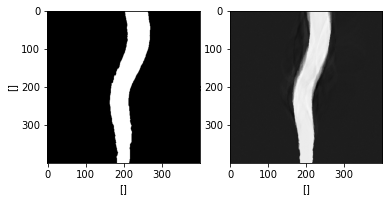

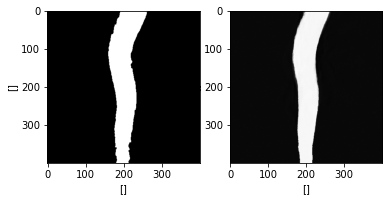

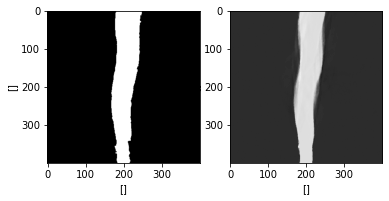

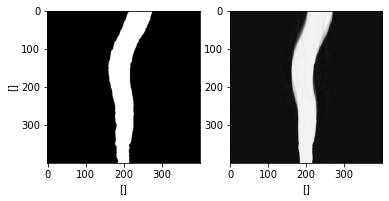

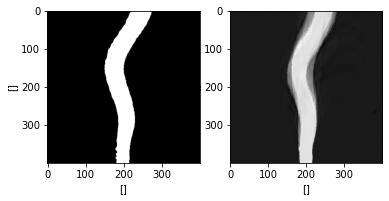

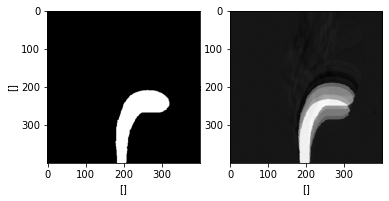

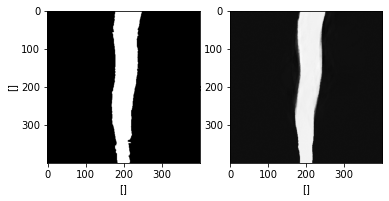

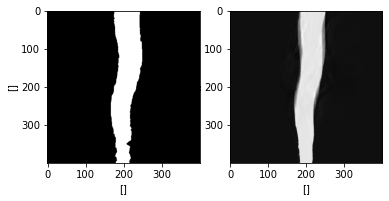

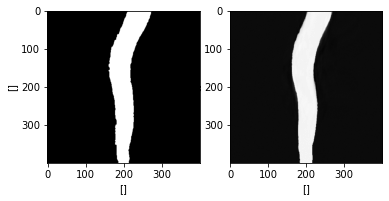

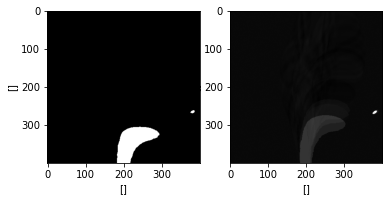

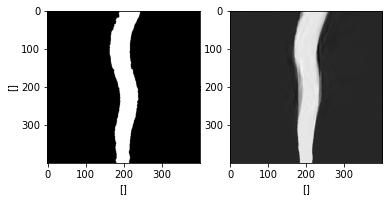

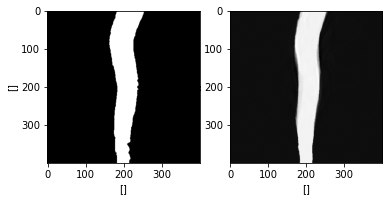

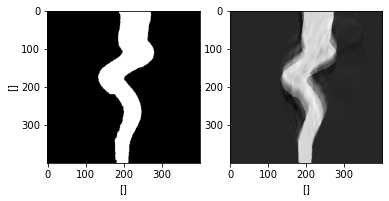

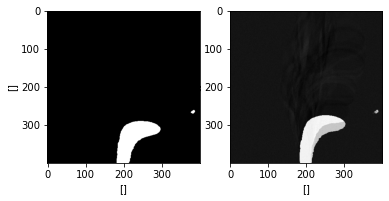

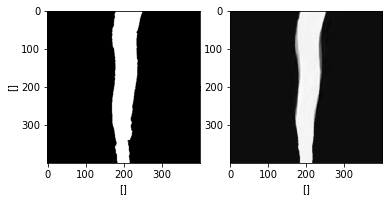

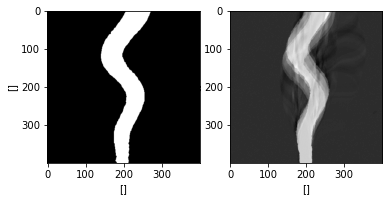

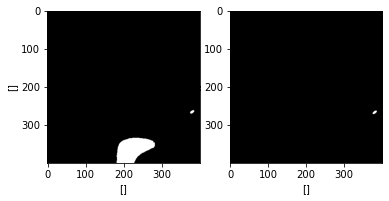

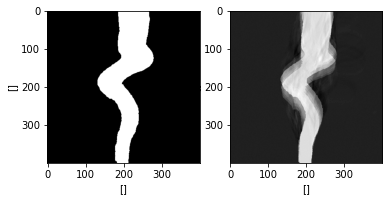

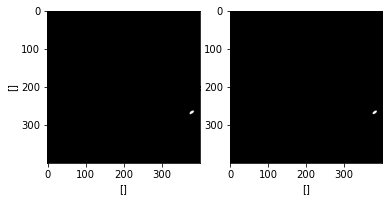

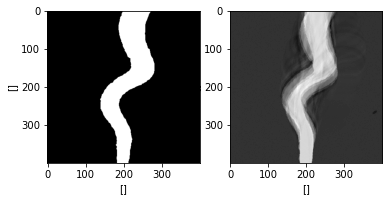

In [12]:
# testing on test data

for i in range(22):
    plt.figure()
    plt.subplot(1,2,1)
    plt.xlabel([]);plt.ylabel([])
    plt.imshow(yy[i,0,:,:,0],cmap='gray')
    
    p = model.predict(xx[i:i+1,:,:,:,:])*255
    plt.subplot(1,2,2)
    plt.xlabel([]);plt.ylabel([])
    plt.imshow(p[0,0,:,:,0],cmap='gray')
    


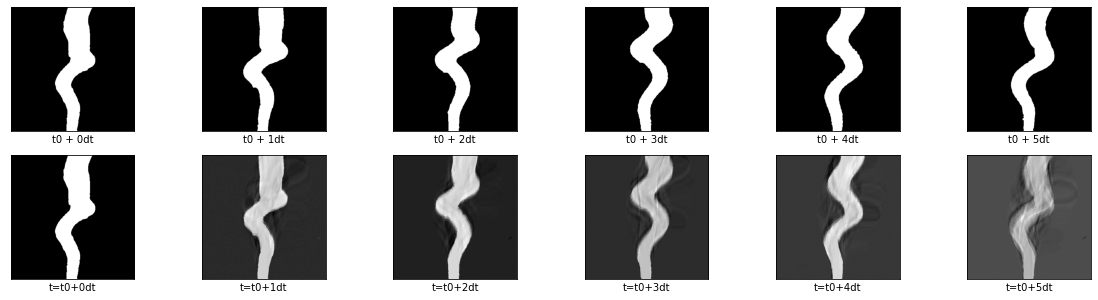

In [34]:
#recursive prediction



N = 150
steps=6
df = 6

frame,row,col,channel = cropped_video.shape
sample = cropped_video[N:N+df*steps:df,:,:,:].reshape(1,steps,row,col,channel)
p = sample[0:1,0:1,:,:,0:1]

for n in range(1):
    plt.figure(n,figsize=(20,5))
    for i in range(1,steps+1):

        input_image = sample[0,i-1,:,:,0]

        plt.subplot(2,steps,i)
        plt.xticks([]);plt.yticks([])
        plt.xlabel(f't0 + {i-1}dt')
        plt.imshow(input_image,cmap='gray')

        
        plt.subplot(2,steps,i+steps)
        plt.xticks([]);plt.yticks([])
        plt.xlabel(f't=t0+{i-1}dt')
        plt.imshow(p[0,0,:,:,0],cmap='gray')
        p = model.predict(p)*255

In [13]:
cropped_video.shape

(450, 400, 400, 1)